This notebook is for exploration of features and predicting the Gibbs energy values.

In [18]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
import glob
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

Read in the kaggle data into a dataframe, convert spacegroup into a string variable.

In [3]:
df = pd.read_csv('../example-data/kaggle-data.csv', index_col=['id'])
n = len(df.columns)
# Convert spacegroup number to a string
df['spacegroup'] = df['spacegroup'].apply(str)

Scale all the non-string variables.

In [4]:
# take all column names except spacegroup
col_numerics = df.columns.values[1:n]

In [5]:
scaled_features = df.copy()
features = scaled_features[col_numerics]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [6]:
scaled_features[col_numerics] = features

In [7]:
scaled_features.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
id,,,,,,,,,,,,,
1,33,0.810885,0.902265,0.284159,-1.162707,-0.013767,0.774800,-0.626795,-0.180793,-0.452319,-0.185047,-1.149271,1.352520
2,194,0.810885,0.902265,0.284159,-1.162707,-0.681399,-0.477888,2.024991,-0.168794,-0.453130,0.974936,0.589810,0.838233
3,227,-0.959526,1.608450,-0.518259,-1.162707,-0.049431,-0.755305,0.251341,0.543833,-0.240849,-2.484970,-0.052977,0.662201
4,167,-1.402128,1.373055,-1.320676,-0.212653,-0.890531,-1.102459,0.172216,-0.191143,-0.450507,0.974905,0.284270,1.263610
5,194,0.810885,-1.451685,1.354050,0.262374,-0.596817,-0.225287,2.199793,-0.185743,-0.452640,0.974426,-1.317414,-0.693305


In [8]:
X = scaled_features.values[:, 0:(n-3)]
# We only care about the Gibbs Formation Energy
Yform = scaled_features.values[:, (n-2)]
# Yband = df.values[:, (n-1)]

In [9]:
X[:, 0]

array(['33', '194', '227', ..., '206', '33', '206'], dtype=object)

In [10]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(
    X, Yform, test_size=0.25, random_state=3393
    )

Feature Engineering via Gradient Boosting Machines

In [11]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

In [12]:
clf = GradientBoostingRegressor(**params)

In [13]:
clf.fit(xtrain1, ytrain1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [14]:
mse = mean_squared_error(ytest1, clf.predict(xtest1))

In [15]:
print('MSE: %.4f' % mse)

MSE: 0.1507


In [16]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

In [19]:
r2_score(ytest1, clf.predict(xtest1))

0.8425705220007711

In [20]:
for i, ypred in enumerate(clf.staged_predict(xtest1)):
    test_score[i] = clf.loss_(ytest1, ypred)

Text(0,0.5,'Deviance')

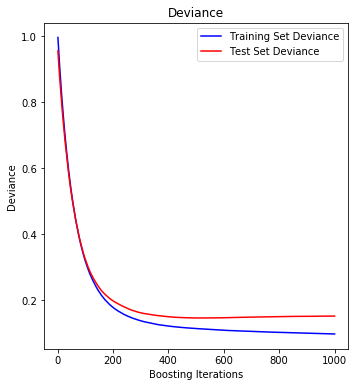

In [142]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('R2 score')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

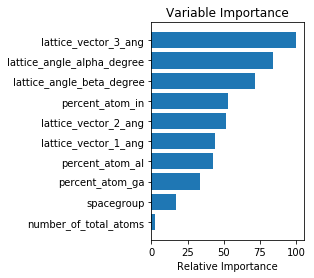

In [143]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1,2,1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [98]:
# pd.plotting.scatter_matrix(df, figsize=(20,20))

In [35]:
pars = np.arange(1, 15, 1)

Looking into how tree depth affects r2 value

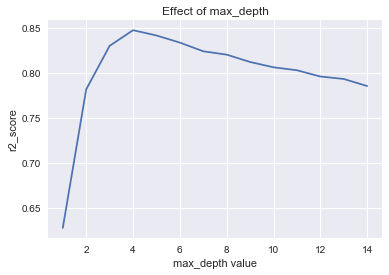

In [36]:
scores = []
for n in pars:
    params1 = {'n_estimators': 450, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = GradientBoostingRegressor(**params1, max_depth=n)
    clf.fit(xtrain1, ytrain1)
    ypred = clf.predict(xtest1)
    test_score = r2_score(ytest1, ypred)
    scores.append(test_score)

sns.set()
plt.title("Effect of max_depth")
plt.xlabel("max_depth value")
plt.ylabel("r2_score")
plt.plot(pars, scores)

In [40]:
pars = np.arange(2, 15, 1)

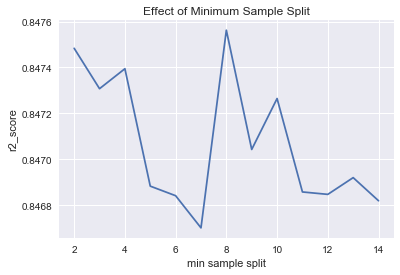

In [41]:
scores = []
for n in pars:
    params1 = {'n_estimators': 450,
          'learning_rate': 0.01, 'loss': 'ls', 'max_depth':4}
    clf = GradientBoostingRegressor(**params1, min_samples_split=n)
    clf.fit(xtrain1, ytrain1)
    ypred = clf.predict(xtest1)
    test_score = r2_score(ytest1, ypred)
    scores.append(test_score)

sns.set()
plt.title("Effect of Minimum Sample Split")
plt.xlabel("min sample split")
plt.ylabel("r2_score")
plt.plot(pars, scores)

In [43]:
pars = np.arange(1, 1000, 50)

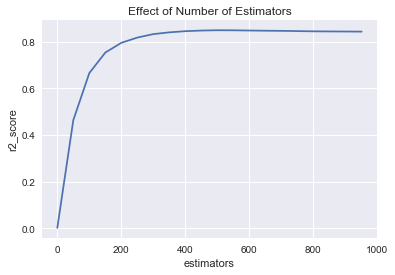

In [44]:
scores = []
for n in pars:
    params1 = {'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls', 'max_depth':4}
    clf = GradientBoostingRegressor(**params1, n_estimators=n)
    clf.fit(xtrain1, ytrain1)
    ypred = clf.predict(xtest1)
    test_score = r2_score(ytest1, ypred)
    scores.append(test_score)

sns.set()
plt.title("Effect of Number of Estimators")
plt.xlabel("estimators")
plt.ylabel("r2_score")
plt.plot(pars, scores)

In [52]:
pars = np.arange(0.001, 0.01, 0.001)
pars

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])

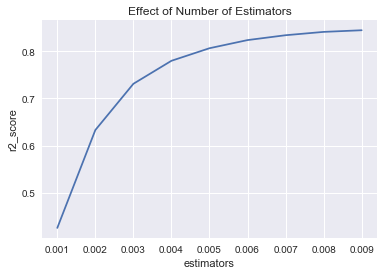

In [53]:
scores = []
for n in pars:
    params1 = {'min_samples_split': 2, 'n_estimators': 450,
          'loss': 'ls', 'max_depth':4}
    clf = GradientBoostingRegressor(**params1, learning_rate=n)
    clf.fit(xtrain1, ytrain1)
    ypred = clf.predict(xtest1)
    test_score = r2_score(ytest1, ypred)
    scores.append(test_score)

sns.set()
plt.title("Effect of Learning Rate")
plt.xlabel("learning rate")
plt.ylabel("r2_score")
plt.plot(pars, scores)